# Chloropleth Map

## Chloropleth Map con Folium

Las coropletas se puede crear fácilmente con folim. 
Los esquemas de color secuenciales de Color Brewer (https://colorbrewer2.org) están integrados en la biblioteca y se pueden pasar para visualizar rápidamente diferentes combinaciones.

In [1]:
import pandas as pd
import folium

url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
state_geo = f'{url}/us-states.json'
state_unemployment = f'{url}/US_Unemployment_Oct2012.csv'
state_data = pd.read_csv(state_unemployment)

m = folium.Map(location=[48, -102], zoom_start=3)

folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=state_data,
    columns=['State', 'Unemployment'],
    key_on='feature.id',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Unemployment Rate (%)'
).add_to(m)

folium.LayerControl().add_to(m)

m

La leyenda en la esquina superior derecha se genera automáticamente. Tambien se pueden pasar rangos predereminados por el usuario.

In [2]:
bins = list(state_data['Unemployment'].quantile([0, 0.25, 0.5, 0.75, 1]))

m = folium.Map(location=[48, -102], zoom_start=3)

folium.Choropleth(
    geo_data=state_geo,
    data=state_data,
    columns=['State', 'Unemployment'],
    key_on='feature.id',
    fill_color='BuPu',
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name='Unemployment Rate (%)',
    bins=bins,
    reset=True
).add_to(m)

m

Los ficheros GeoJson y TopoJson aceptan "style_function" para permitir una mayor personalización del mapa.

In [3]:
import branca
import requests
import json

url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
county_data = f'{url}/us_county_data.csv'
county_geo = f'{url}/us_counties_20m_topo.json'


df = pd.read_csv(county_data, na_values=[' '])

colorscale = branca.colormap.linear.YlOrRd_09.scale(0, 50e3)
employed_series = df.set_index('FIPS_Code')['Employed_2011']


def style_function(feature):
    employed = employed_series.get(int(feature['id'][-5:]), None)
    return {
        'fillOpacity': 0.5,
        'weight': 0,
        'fillColor': '#black' if employed is None else colorscale(employed)
    }


m = folium.Map(
    location=[48, -102],
    tiles='cartodbpositron',
    zoom_start=3
)

folium.TopoJson(
    json.loads(requests.get(county_geo).text),
    'objects.us_counties_20m',
    style_function=style_function
).add_to(m)


m

## Chloropleth Map con Geopandas

Con geopandas podemos colorear areas basos en una determinada columa de geodataframe.
Es muy importante antes de representar un mapa de coropletas normalizar los datos.

In [4]:
import geopandas as gpd
countries = gpd.read_file("https://minsait-geospatial.s3.eu-west-3.amazonaws.com/data/Visualization/ne_110m_admin_0_countries.zip")
countries = countries[(countries['pop_est'] >0 ) & (countries['name'] != "Antarctica")]
countries['gdp_per_cap'] = countries['gdp_md_est'] / countries['pop_est'] * 100

En este ejemplo se muestran en una escala continua, por lo que no se representan bien la variabilidad entre países.

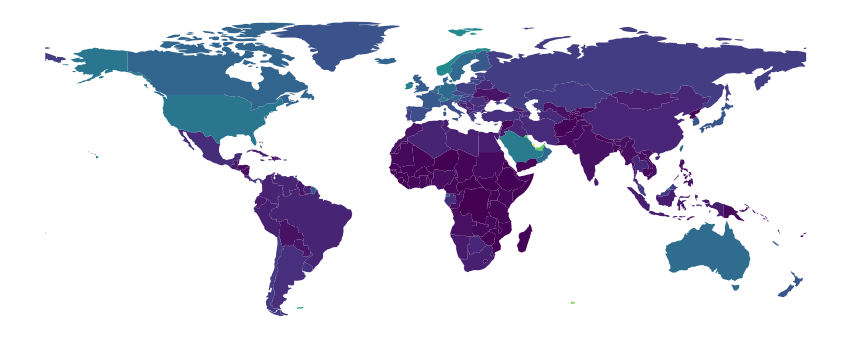

In [5]:
ax = countries.plot(figsize=(15, 15), column='gdp_per_cap')
ax.set_axis_off()

Posteriormente usamos una escala de cuartiles para presentar los datos.

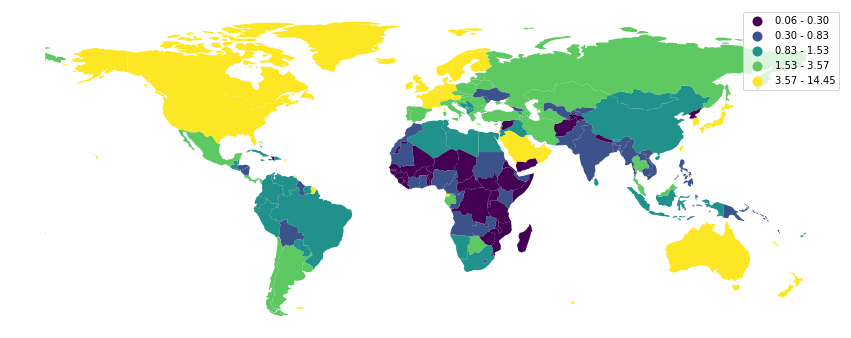

In [6]:
ax = countries.plot(figsize=(15, 15), column='gdp_per_cap', scheme='quantiles', legend=True)
ax.set_axis_off()

## Chloropleth Map con Geoplot

Geoplot proporcionan algunas funcionalidades adicionales en comparación con el método básico .plot () en GeoDataFrames:
    API de trazado de alto nivel (con más tipos de proyecciones que geopandas)
    Soporte de proyección nativa a través de cartopy
    Notar que nos podemos centrar en cualquier lugar del globo con central_latitude y central_longitude

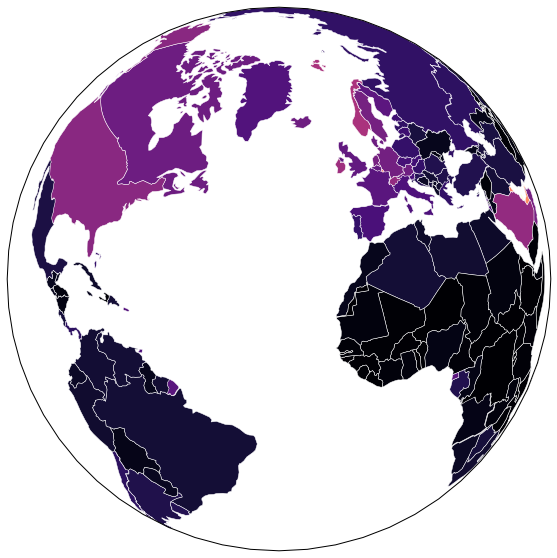

In [7]:
import geoplot
import geoplot.crs as gcrs
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={
    'projection': gcrs.Orthographic(central_latitude=30, central_longitude=-30)
})
geoplot.choropleth(countries, hue='gdp_per_cap', projection=gcrs.Orthographic(), ax=ax,
                   cmap='magma', linewidth=0.5, edgecolor='white')
ax.set_global()
ax.outline_patch.set_visible(True)

In [8]:
countries.head()

iso_a3                  name      continent     pop_est  gdp_md_est  \
0    AFG           Afghanistan           Asia  34124811.0     64080.0   
1    AGO                Angola         Africa  29310273.0    189000.0   
2    ALB               Albania         Europe   3047987.0     33900.0   
3    ARE  United Arab Emirates           Asia   6072475.0    667200.0   
4    ARG             Argentina  South America  44293293.0    879400.0   

                                            geometry  gdp_per_cap  
0  POLYGON ((61.21082 35.65007, 62.23065 35.27066...     0.187781  
1  MULTIPOLYGON (((23.90415 -11.72228, 24.07991 -...     0.644825  
2  POLYGON ((21.02004 40.84273, 20.99999 40.58000...     1.112209  
3  POLYGON ((51.57952 24.24550, 51.75744 24.29407...    10.987283  
4  MULTIPOLYGON (((-66.95992 -54.89681, -67.56244...     1.985402

In [9]:
import plotly.express as px
import plotly.offline as py
py.init_notebook_mode(connected=False)

df = px.data.gapminder().query("year==2007")
fig = px.choropleth(countries, 
                    color="gdp_per_cap", # lifeExp is a column of gapminder
                    color_continuous_scale=px.colors.sequential.Plasma)
fig.show()